## Import Librairies 

In [1]:
import os  
import time
import numpy as np
import pandas as pd
import pyttsx3
os.environ["HTTP_PROXY"] = "http://127.0.0.1:9000/localproxy.pac"
import speech_recognition as sr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import joblib

In [2]:
"""
def shuffler(filename):
  df = pd.read_csv(filename, header=0,dtype=object,na_filter=False)
  # return the pandas dataframe
  return df.reindex(np.random.permutation(df.index))

def main(outputfilename):
  shuffler("../Datasets/national_names.csv").to_csv(outputfilename, sep=',',encoding = 'utf-8',index = False)
main("../Datasets/national_names_shuf.csv")"""

'\ndef shuffler(filename):\n  df = pd.read_csv(filename, header=0,dtype=object,na_filter=False)\n  # return the pandas dataframe\n  return df.reindex(np.random.permutation(df.index))\n\ndef main(outputfilename):\n  shuffler("../Datasets/national_names.csv").to_csv(outputfilename, sep=\',\',encoding = \'utf-8\',index = False)\nmain("../Datasets/national_names_shuf.csv")'

### Preprocessing Data

In [3]:
engine = pyttsx3.init()

df_m=pd.read_csv("../Datasets/national_names_shuf.csv")[0:480000] #80% du dataset
df_m.head()
df_m.isnull().values.any()
df_m.sex.unique()
#print(df_m.drop(["year","count"],axis=1).head())
df_m.sex=[0 if each=="M" else 1 for each in df_m.sex]
y=df_m.sex
def clean(word):
    return re.sub('[^a-zA-Z]','',word)
df_m["name"]=df_m["name"].apply(clean)
print(df_m.drop(["year","count"],axis=1).head())
print(df_m.describe())

       name  sex
0  Leonardo    0
1  Norberto    0
2  Katarina    1
3    Nacera    1
4    Tanita    1
                year            sex          count
count  480000.000000  480000.000000  480000.000000
mean     1981.641483       0.544446     138.554423
std        31.233541       0.498021     926.394079
min      1900.000000       0.000000       3.000000
25%      1964.000000       0.000000       4.000000
50%      1991.000000       1.000000       8.000000
75%      2007.000000       1.000000      24.000000
max      2018.000000       1.000000   53706.000000


### Multinomial NB

In [4]:
cv_mnb = CountVectorizer()
Xfeatures=df_m["name"]
X_mnb = cv_mnb.fit_transform(Xfeatures)
X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(X_mnb, y, test_size=0.2, random_state=42)
# training the model on training set
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
start_time_mnb = time.time()
mnb.fit(X_train_mnb, y_train_mnb)
print("-----------------------Training time is : %s seconds -------------------------------------" % (time.time() - start_time_mnb))
# making predictions on the testing set
print("the score is ",mnb.score(X_test_mnb,y_test_mnb))
y_pred_mnb=mnb.predict(X_test_mnb)
accuracy_mnb=metrics.accuracy_score(y_test_mnb, y_pred_mnb)
print("Accuracy of Multinomial NB:",accuracy_mnb)
print("Confusion Matrix:\n",confusion_matrix(y_pred_mnb,y_test_mnb))

-----------------------Training time is : 0.058963775634765625 seconds -------------------------------------
the score is  0.9480104166666666
Accuracy of Multinomial NB: 0.9480104166666666
Confusion Matrix:
 [[41170  2551]
 [ 2440 49839]]


#### Recording Audio 

In [5]:
def genderpredictor(a):
    test_name = [a]
    vector = cv_mnb.transform(test_name).toarray()
    if mnb.predict(vector) == 1:
        return "Female"
    else:
        return "Male"
"""
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Say something!")
    audio = r.listen(source)
str1=r.recognize_google(audio,language="fr-FR").lower()
print("you said ",str1)"""

'\nr = sr.Recognizer()\nwith sr.Microphone() as source:\n    print("Say something!")\n    audio = r.listen(source)\nstr1=r.recognize_google(audio,language="fr-FR").lower()\nprint("you said ",str1)'

#### Classify name 

In [6]:
print(genderpredictor("mouhammed"))

"""e
out=str1+" is a "+
print(str(out))
engine.say(out)
engine.runAndWait()
"""

M


'e\nout=str1+" is a "+\nprint(str(out))\nengine.say(out)\nengine.runAndWait()\n'

### Validation

In [7]:
df_v=pd.read_csv("../Datasets/national_names_shuf.csv")[480000:-1] #20% du dataset for validation
df_v["name"]=df_v["name"].apply(clean)
df_v.drop(["year","count"],axis=1)
def predvalues():
    val=[]
    for name in df_v["name"]:
        val.append(genderpredictor(name)[0])
    return val
exact_values=df_v["sex"].values.tolist()
val=predvalues()

In [8]:
#print(df_v["sex"].loc[df_v["name"]=="Pina"])
import collections as clct
val_clt=clct.Counter(val)
exact_values_clt=clct.Counter(exact_values)
score=1-(abs(val_clt['F']-exact_values_clt['F'])+abs(val_clt['M']-exact_values_clt['M']))/len(val)
print("Validation Score MNB: ",score)
#print(df_v["name"].iloc[40])
#print(genderpredictor("test"))

Validation Score MNB:  0.9963702958208907


#### Saving Model

In [9]:
filename = 'mnb_model.sav'
joblib.dump(mnb, filename)
loaded_mnb_model = joblib.load(filename)
result = loaded_mnb_model.score(X_test_mnb, y_test_mnb)
print(result)

0.9480104166666666


### Decision Tree

#### Feature Extraction

In [10]:
def features(name):
    name = name.lower()
    return {
        'first-letter': name[0], # First letter
        'first2-letters': name[0:2], # First 2 letters
        'first3-letters': name[0:3], # First 3 letters
        'last-letter': name[-1],
        'last2-letters': name[-2:],
        'last3-letters': name[-3:],
    }
features = np.vectorize(features)

In [11]:
X_train_features_dtree = features(df_m['name'])

dv_dtree = DictVectorizer()

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_train_features_dtree , y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeClassifier
dv_dtree.fit_transform(X_train_tree)
dclf = DecisionTreeClassifier()
my_xfeatures =dv_dtree.transform(X_train_tree)
start_time_dtree=time.time()
dclf.fit(my_xfeatures, y_train_tree)
print("-----------------------Training Decision Tree %s seconds -------------------------------------" % (time.time() - start_time_dtree))
y_pred_tree= dclf.predict(dv_dtree.transform(X_test_tree))
accuracy_dtree=metrics.accuracy_score(y_test_tree, y_pred_tree)
print("Accuracy of Decision Tree Classifier:",accuracy_dtree)
print("Confusion Matrix:\n",confusion_matrix(y_pred_tree,y_test_tree))

-----------------------Training Decision Tree 36.59660840034485 seconds -------------------------------------
Accuracy of Decision Tree Classifier: 0.946375
Confusion Matrix:
 [[41383  2921]
 [ 2227 49469]]


#### Recording Audio 

In [12]:
def genderpredictor_tree(a):
    test_name_tree = [a]
    vector_tree = dv_dtree.transform(features(test_name_tree)).toarray()
    if dclf.predict(vector_tree) == 1:
        return "Female"
    else:
        return "Male"
"""
r_tree = sr.Recognizer()
with sr.Microphone() as source:
    print("Say something!")
    audio = r_tree.listen(source)
str2=r_tree.recognize_google(audio,language="fr-FR").lower()
print("you said ",str2)"""

'\nr_tree = sr.Recognizer()\nwith sr.Microphone() as source:\n    print("Say something!")\n    audio = r_tree.listen(source)\nstr2=r_tree.recognize_google(audio,language="fr-FR").lower()\nprint("you said ",str2)'

#### Classify name

In [13]:
print(genderpredictor_tree("rachid"))
"""
out_tree=str2+" is a "+genderpredictor_tree(str2)
print(str(out_tree))
engine.say(out_tree)
engine.runAndWait()"""

M


'\nout_tree=str2+" is a "+genderpredictor_tree(str2)\nprint(str(out_tree))\nengine.say(out_tree)\nengine.runAndWait()'

In [14]:
print(df_v["name"].iloc[62023])
print(genderpredictor(df_v["name"].iloc[62023]))

Dawn
F


### Validation

In [15]:
df_v=pd.read_csv("../Datasets/national_names_shuf.csv")[480000:-1] #20% du dataset for validation
df_v["name"]=df_v["name"].apply(clean)
df_v.drop(["year","count"],axis=1)
def predvalues_tree():
    val=[]
    for name in df_v["name"]:
        val.append(genderpredictor_tree(name)[0])
    return val
exact_values_tree=df_v["sex"].values.tolist()
val_tree=predvalues_tree()

In [16]:
val_tree_clt=clct.Counter(val_tree)
exact_values_tree_clt=clct.Counter(exact_values_tree)
score_tree=1-(abs(val_tree_clt['F']-exact_values_tree_clt['F'])+abs(val_tree_clt['M']-exact_values_tree_clt['M']))/len(val_tree)
print("Validation Score DTree: ",score_tree)

65124
66024
Validation Score DTree:  0.9851512101763706


#### Saving Model

In [17]:
filename = 'dtree_model.sav'
joblib.dump(dclf, filename)
loaded_dtree_model = joblib.load(filename)
y_pred_tree= loaded_dtree_model.predict(dv_dtree.transform(X_test_tree))
accuracy_dtree=metrics.accuracy_score(y_test_tree, y_pred_tree)
print(accuracy_dtree)

0.946375


### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf_randomForrest = RandomForestClassifier(random_state = 1)
X_train_features_randomForrest = features(df_m['name'])

dv_randomForrest = DictVectorizer()

X_train_randomForrest, X_test_randomForrest, y_train_randomForrest, y_test_randomForrest = train_test_split(X_train_features_randomForrest , y, test_size=0.33, random_state=42)
dv_randomForrest.fit_transform(X_train_randomForrest)
my_xfeatures_randomForrest =dv_randomForrest.transform(X_train_randomForrest)
start_time_rForest=time.time()
clf_randomForrest.fit(my_xfeatures_randomForrest, y_train_randomForrest)
print("-----------------------Training Random Forest  %s seconds -------------------------------------" % (time.time() - start_time_rForest))
y_pred_randomForrest= clf_randomForrest.predict(dv_randomForrest.transform(X_test_randomForrest))
accuracy_randomForrest=metrics.accuracy_score(y_test_randomForrest, y_pred_randomForrest)
print("Accuracy of Random Forrest:",accuracy_randomForrest)
print("Confusion Matrix:\n",confusion_matrix(y_pred_randomForrest,y_test_randomForrest))

-----------------------Training Random Forest  693.3444504737854 seconds -------------------------------------
Accuracy of Random Forrest: 0.9463383838383839
Confusion Matrix:
 [[68346  4637]
 [ 3863 81554]]


#### Recording Audio (Input)

In [19]:
def genderpredictor_r(a):
    test_name_tree = [a]
    vector_tree = dv_randomForrest.transform(features(test_name_tree)).toarray()
    if clf_randomForrest.predict(vector_tree) == 1:
        return "Female"
    else:
        return "Male"
"""
r_r = sr.Recognizer()
with sr.Microphone() as source:
    print("Say something!")
    audio = r_r.listen(source)
str3=r_r.recognize_google(audio,language="fr-FR").lower()
print("you said ",str3)"""

'\nr_r = sr.Recognizer()\nwith sr.Microphone() as source:\n    print("Say something!")\n    audio = r_r.listen(source)\nstr3=r_r.recognize_google(audio,language="fr-FR").lower()\nprint("you said ",str3)'

#### Classify name 

In [20]:
print(genderpredictor_r("rachid"))
"""
out_r=str3+" is a "+genderpredictor_r(str3)
print(out_r)
engine.say(out_r)
engine.runAndWait()"""

M


'\nout_r=str3+" is a "+genderpredictor_r(str3)\nprint(out_r)\nengine.say(out_r)\nengine.runAndWait()'

In [21]:
print(df_v["name"].iloc[12010])
print(genderpredictor_r(df_v["name"].iloc[12010]))

Ilian
M


### Validation 

In [22]:
df_v=pd.read_csv("../Datasets/national_names_shuf.csv")[480000:-1] #20% du dataset for validation
df_v["name"]=df_v["name"].apply(clean)
df_v.drop(["year","count"],axis=1)
def predvalues_rf():
    val=[]
    for name in df_v["name"]:
        val.append(genderpredictor_r(name)[0])
    return val
exact_values_rf=df_v["sex"].values.tolist()
val_rf=predvalues_rf()

In [23]:
val_rf_clt=clct.Counter(val_rf)
exact_values_rf_clt=clct.Counter(exact_values_rf)
print(val_rf_clt['F'])
print(exact_values_rf_clt['F'])
score_rf=1-(abs(val_rf_clt['F']-exact_values_rf_clt['F'])+abs(val_rf_clt['M']-exact_values_rf_clt['M']))/len(val_rf)
print("Validation Score RForest: ",score_rf)

65326
66024
Validation Score RForest:  0.9884839385590074


### Saving Model 

In [24]:
filename = 'rf_model.sav'
joblib.dump(clf_randomForrest, filename)
loaded_rF_model = joblib.load(filename)
y_pred_rForest= loaded_rF_model.predict(dv_randomForrest.transform(X_test_randomForrest))
accuracy_rF=metrics.accuracy_score(y_test_randomForrest, y_pred_rForest)
print(accuracy_rF)

0.9463383838383839


### Results 

#### Display Accuracy

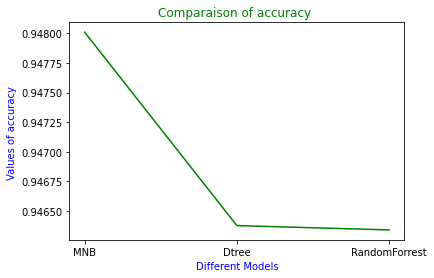

In [25]:
list_accuracy=[accuracy_mnb,accuracy_dtree,accuracy_randomForrest]
x=['MNB','Dtree','RandomForrest']
plt.plot(x,list_accuracy,label='linear',color='g')
plt.xlabel('Different Models').set_color('blue')
plt.ylabel('Values of accuracy ').set_color('blue')
plt.title('Comparaison of accuracy ').set_color('green')

#### ROC AUC

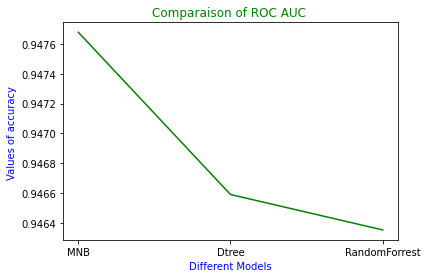

In [26]:
y_roc_auc_score_mnb=roc_auc_score(y_test_mnb, y_pred_mnb, average='weighted')
y_roc_auc_score_dtree=roc_auc_score(y_test_tree, y_pred_tree, average='weighted')
y_roc_auc_score_randomForrest=roc_auc_score(y_test_randomForrest, y_pred_randomForrest, average='weighted')
list_accuracy=[y_roc_auc_score_mnb,y_roc_auc_score_dtree,y_roc_auc_score_randomForrest]
x=['MNB','Dtree','RandomForrest']
plt.plot(x,list_accuracy,label='linear',color='g')
plt.xlabel('Different Models').set_color('blue')
plt.ylabel('Values of accuracy ').set_color('blue')
plt.title('Comparaison of ROC AUC ').set_color('green')

#### ROC Curve

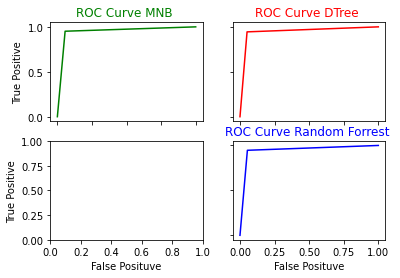

In [27]:
false_positive_mnb, true_positive_mnb, threshold_mnb = roc_curve(y_test_mnb, y_pred_mnb)
false_positive_tree, true_positive_tree, threshold_tree = roc_curve(y_test_tree, y_pred_tree)
false_positive_randomForrest, true_positive_randomForrest, threshold_randomForrest = roc_curve(y_test_randomForrest, y_pred_randomForrest)
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(false_positive_mnb,true_positive_mnb,color='g')
axs[0,0].set_title('ROC Curve MNB ').set_color('green')
axs[0,1].plot(false_positive_tree,true_positive_tree,color='r')
axs[0,1].set_title('ROC Curve DTree ').set_color('red')
axs[1,1].plot(false_positive_randomForrest,true_positive_randomForrest,color='b')
axs[1,1].set_title('ROC Curve Random Forrest ').set_color('blue')
for ax in axs.flat:
    ax.set(xlabel='False Posituve', ylabel='True Positive')
for ax in fig.get_axes():
    ax.label_outer()